## Ćwiczenie 9 - wersja uproszczona i wytłumaczona

Załóżmy, że mamy dane pochodzące z rozkładu normalnego o wariancji równej 1 i średniej $\mu$. Będziemy estymowali $\mu$ korzystając z wzoru Bayesa.

1. Stworzyć siatkę 1001 punktów na odcinku $[0,10]$ - to będą nasze potencjalne średnie.
2. Wylosować jeden punkt z siatki - to będzie "prawdziwa" średnia rozkładu. Oczywiście model jej nie zna.
3. Przyjąć jednostajny rozkład a priori (użyć floatów z największą możliwą precyzją).
4. Powtórzyć nb_iters razy:
    - wygenerować nb_samples sampli z prawdziwego rozkładu,
    - uaktualnić knowledge na podstawie obserwacji,
    - narysować knowledge.

In [1]:
import numpy as np
from scipy.stats import norm
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# tworzymy siatkę, której elementy reprezentują możliwe rozkłady P
# każdy element \theta reprezentuje jeden rozkład Gaussa o średniej \theta i wariancji 1
mesh = np.linspace(0., 10., 1001, dtype=np.float128)

# definiujemy rozkład a priori
# jeśli wiemy, że prawdziwa średnia jest losowana jednostajnie z siatki,
# to sensownie jest wziąć również rozkład jednostajny jako rozkład a priori
prior = np.ones(mesh.shape, dtype=np.float128) / float(len(mesh))

# umówmy się, że nasza wiedza jest reprezentowana (dla wygody) przez tuple:
knowledge = (mesh, prior)

# losujemy jednostajnie indeks od 0 do 1000, ja wylosowałem 0
true_mean = mesh[0]
true_stdev = 1.

# dla wygody opakujmy powyższe następującymi funkcjami

def initialize_knowledge(l_interval=0., r_interval=10., mesh_size=1001, random_state=743):
    rng = np.random.RandomState(random_state)
    mesh = np.linspace(l_interval, r_interval, mesh_size, dtype=np.float128)
    prior = np.ones(mesh.shape, dtype=np.float128) / float(len(mesh))
    knowledge = (mesh, prior)
    return knowledge

def initialize_true_distribution(knowledge, random_state=743):
    rng = np.random.RandomState(random_state)
    mesh = knowledge[0]
    true_mean = mesh[rng.randint(0,len(mesh))]
    true_stdev = 1.
    return true_mean, true_stdev

# inicjalizacja jeszcze raz
knowledge = initialize_knowledge(l_interval=0., r_interval=10., mesh_size=1001, random_state=743)
true_mean, true_stdev = initialize_true_distribution(knowledge, random_state=743)
print "true_mean:", true_mean
print "true_stdev:", true_stdev

true_mean: 7.9
true_stdev: 1.0


In [3]:
# napiszmy jeszcze kilka funkcji przydatnych do wizualizacji

def plot_knowledge(knowledge, title="Knowledge"):
    mesh, prior = knowledge
    plt.plot(mesh, prior)
    plt.title(title)
    plt.show()

def plot_observations(observations):
    plt.hist(observations, bins=max(len(observations)/100, 10))
    plt.title("Observations histogram")
    plt.show()

def plot_learning(prior_knowledge, observations, nb_batch, batch_size):
    assert nb_batch * batch_size <= len(observations)
    posterior_knowledge = prior_knowledge
    plot_knowledge(posterior_knowledge, title="Prior knowledge")
    for i in xrange(nb_batch):
        posterior_knowledge = calculate_posterior_knowledge(posterior_knowledge, observations[i*batch_size:(i+1)*batch_size])
        plot_knowledge(posterior_knowledge, title="Knowledge after " + str((i+1)*batch_size) + " observations")

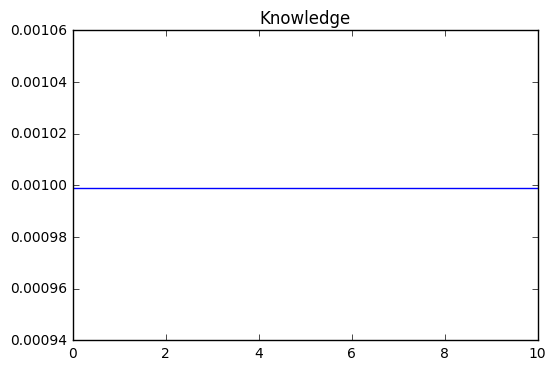

In [4]:
# rysujemy naszą wiedzę a priori
plot_knowledge(knowledge)

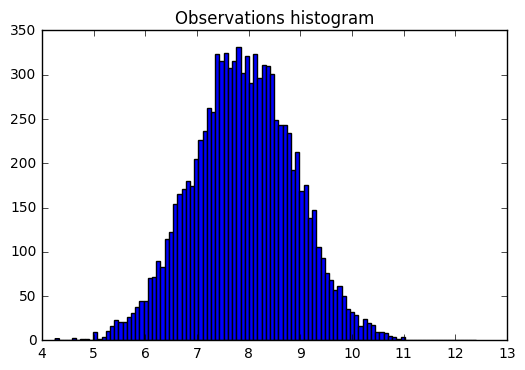

In [5]:
# ustalamy seed generatora liczb losowych
# losujemy 10k obserwacji z prawdziwego rozkładu normalnego
rng = np.random.RandomState(743)
observations = rng.normal(loc=true_mean, scale=true_stdev, size=10000)

# narysujmy (nieznormalizowany) histogram wylosowanych obserwacji
plot_observations(observations)

In [6]:
def gaussian_likelihood(mean, stdev, observations):
    return np.prod(norm.pdf(observations, loc=mean, scale=stdev))

def calculate_posterior_knowledge(knowledge, observations):
    mean_mesh, prior = knowledge
    likelihood = np.array([gaussian_likelihood(mean, 1., observations) for mean in mean_mesh])
    nom = prior * likelihood
    posterior = nom / np.sum(nom)
    return (mean_mesh, posterior)

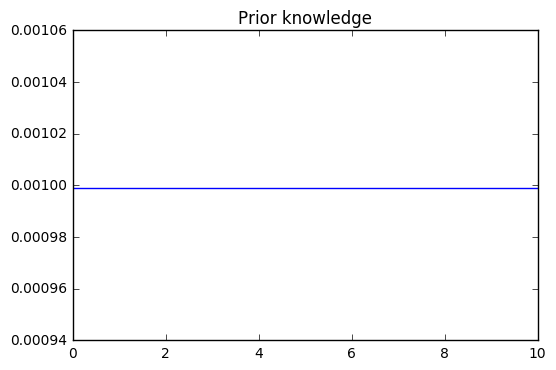

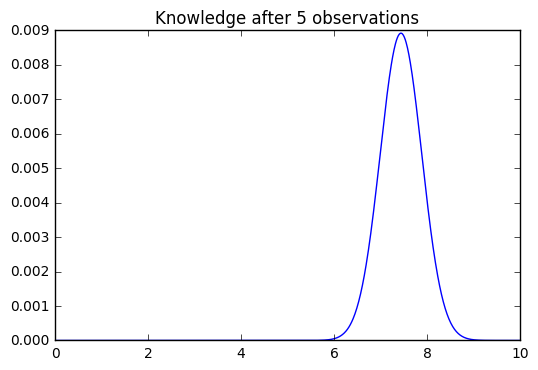

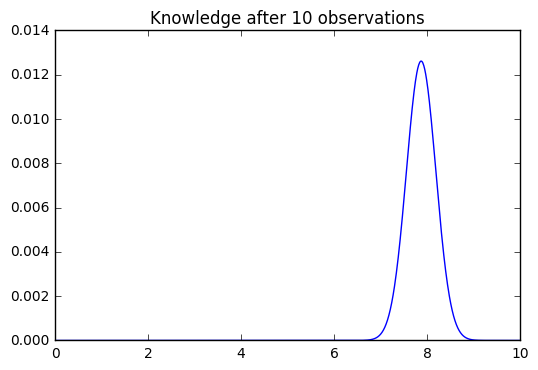

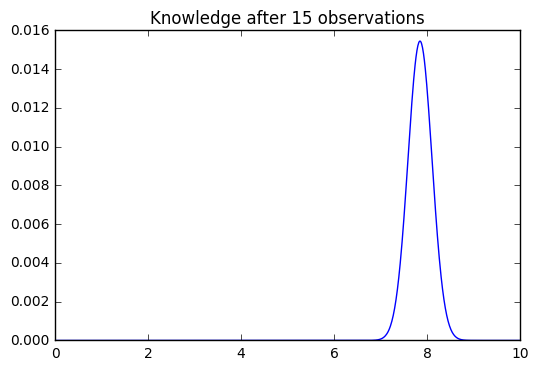

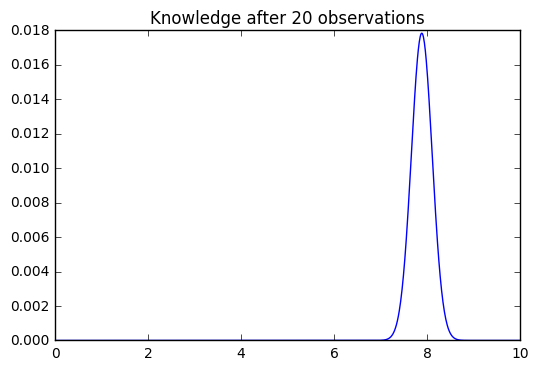

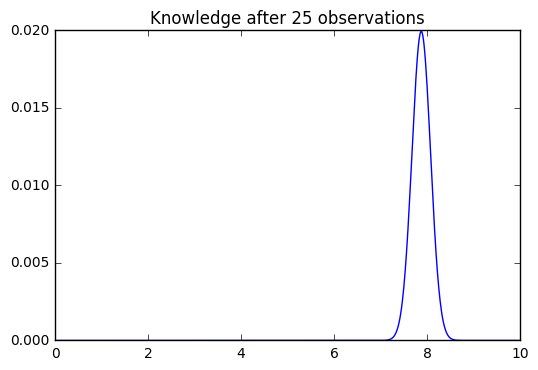

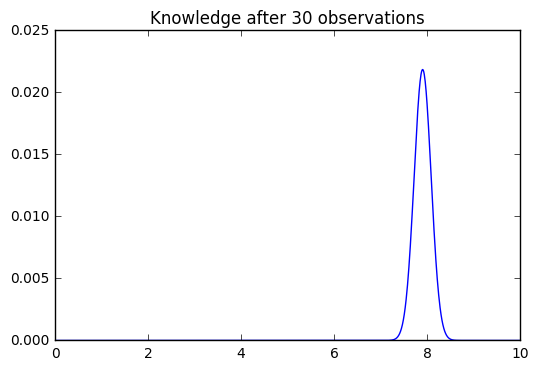

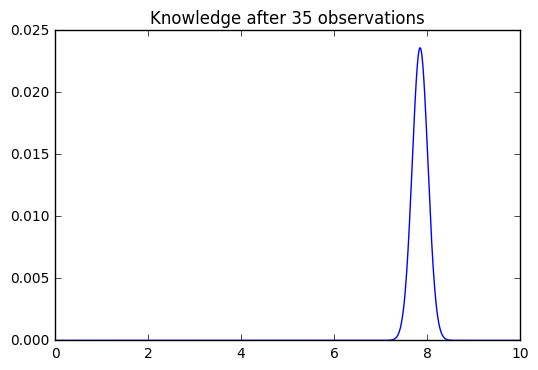

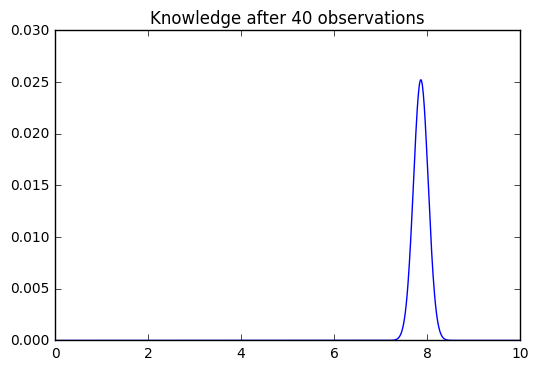

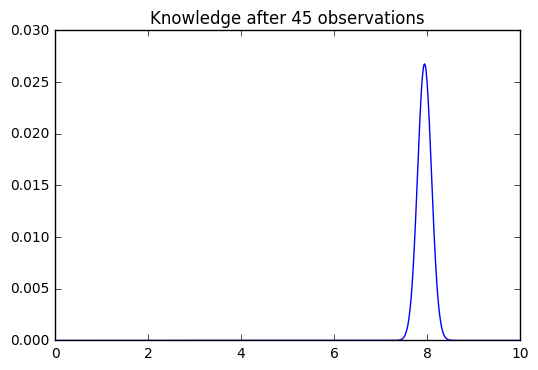

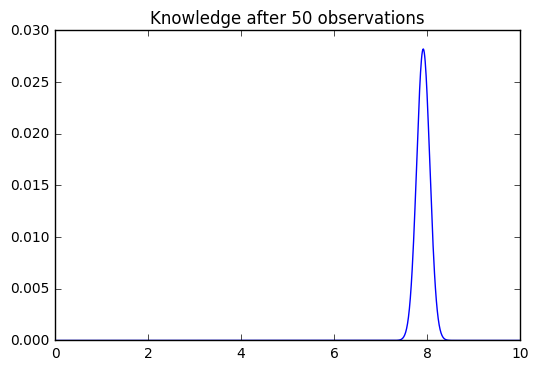

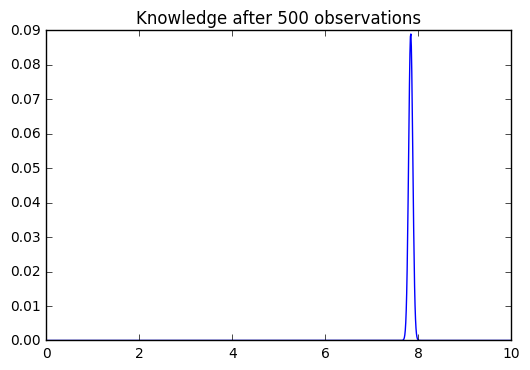

In [7]:
# narysujmy teraz, jak wygląda uczenie się naszego modelu
plot_learning(prior_knowledge=knowledge, observations=observations, nb_batch=10, batch_size=5)
# po 500 obserwacjach model jest już w miarę pewny wyniku, 1000 obserwacji rzuca błędem dzielenia przez zero
plot_knowledge(calculate_posterior_knowledge(knowledge, observations[:500]), title="Knowledge after 500 observations")

true_mean: 4.3
true_stdev: 1.0


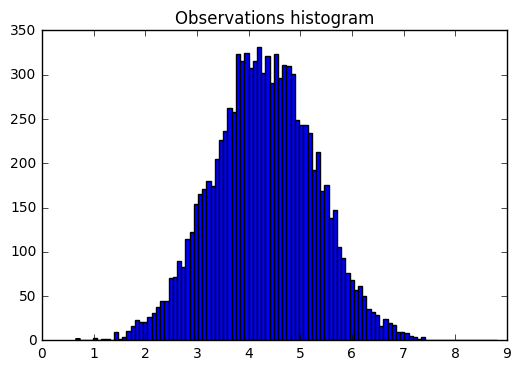

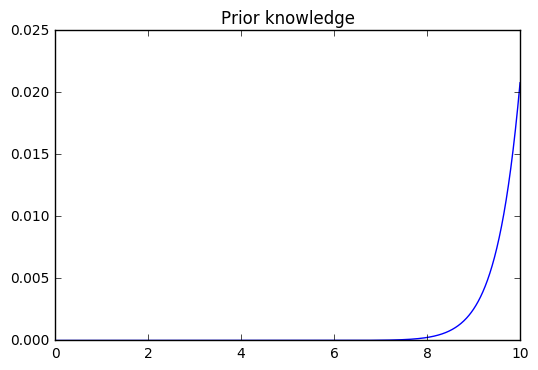

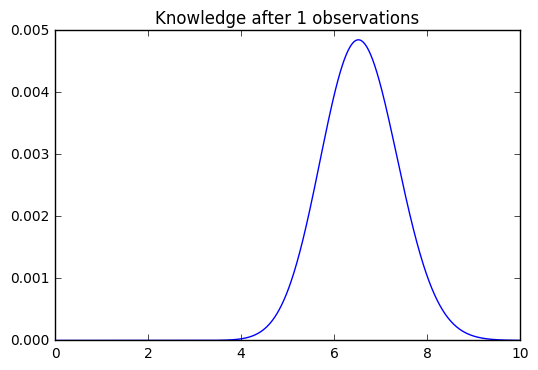

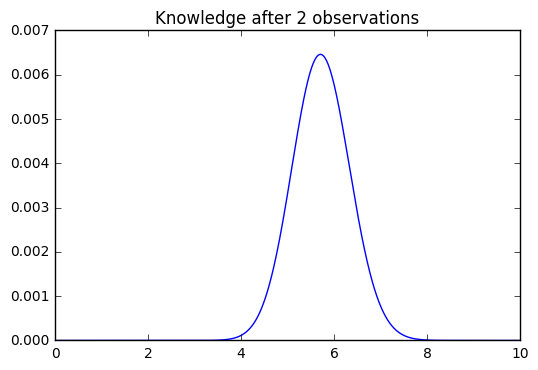

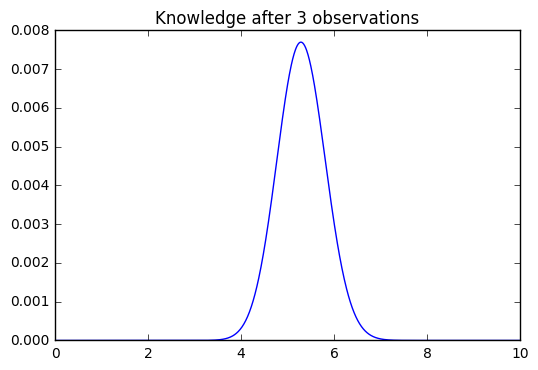

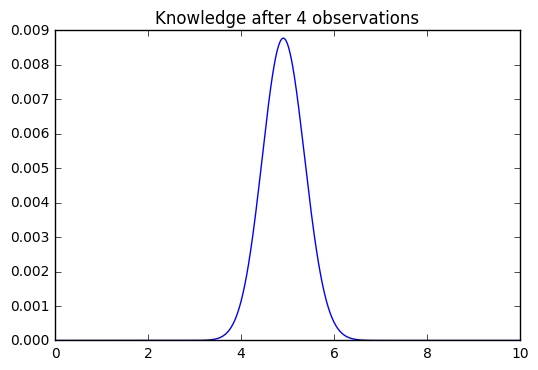

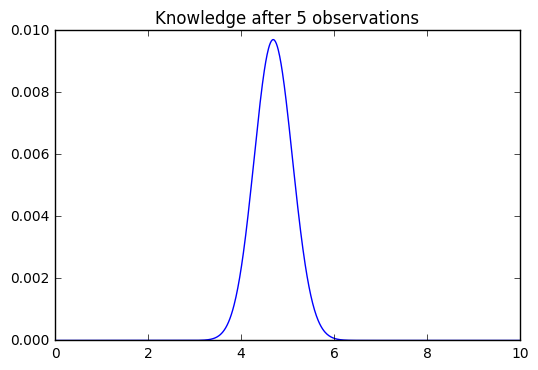

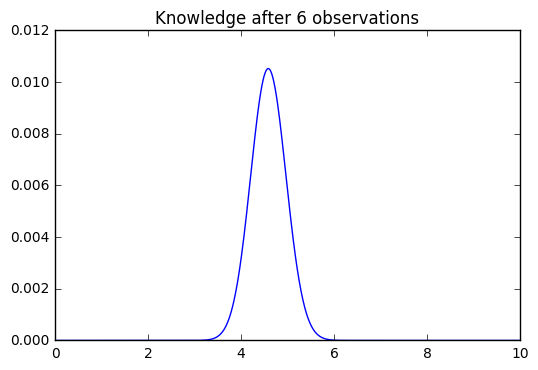

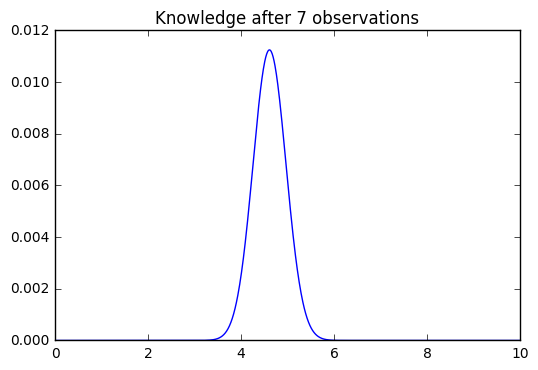

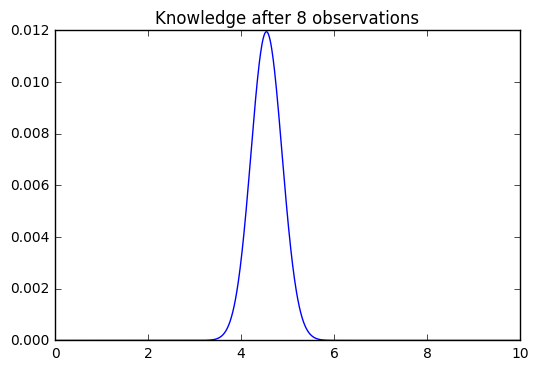

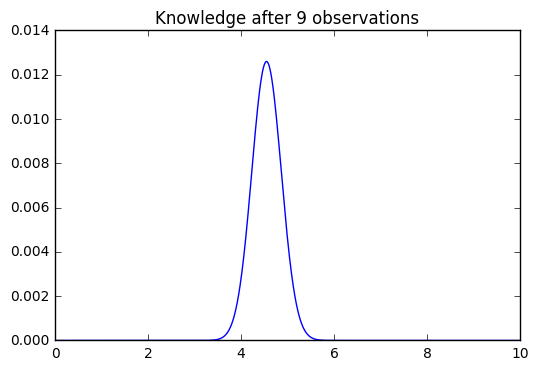

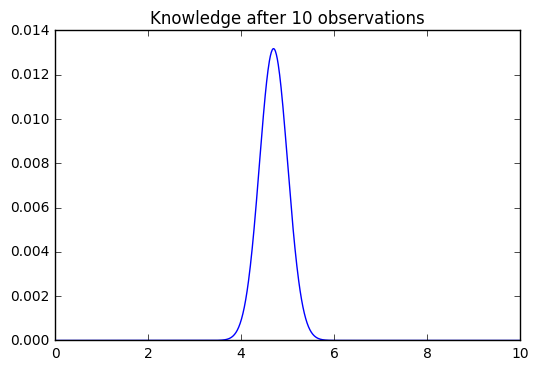

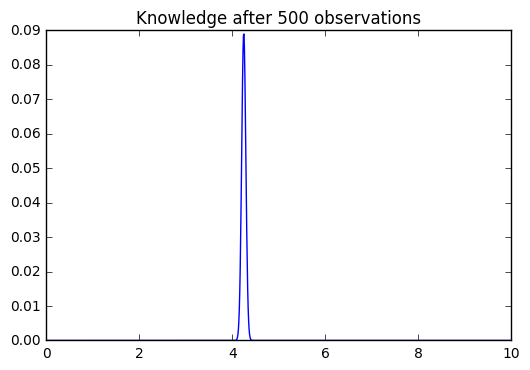

In [8]:
# zmieńmy rozkład a priori na niejednostajny i zobaczmy, jak zmienia się proces uczenia
knowledge = initialize_knowledge()
true_mean = 4.3
mesh, prior = knowledge
prior = mesh**20
prior /= np.sum(prior)
knowledge = (mesh, prior)
print "true_mean:", true_mean
print "true_stdev:", true_stdev
rng = np.random.RandomState(743)
observations = rng.normal(loc=true_mean, scale=true_stdev, size=10000)
plot_observations(observations)
plot_learning(prior_knowledge=knowledge, observations=observations, nb_batch=10, batch_size=1)
plot_knowledge(calculate_posterior_knowledge(knowledge, observations[:500]), title="Knowledge after 500 observations")
# dość szybko (po kilku obserwacjach) model uczy się sensownych rzeczy

true_mean: 14.3
true_stdev: 1.0


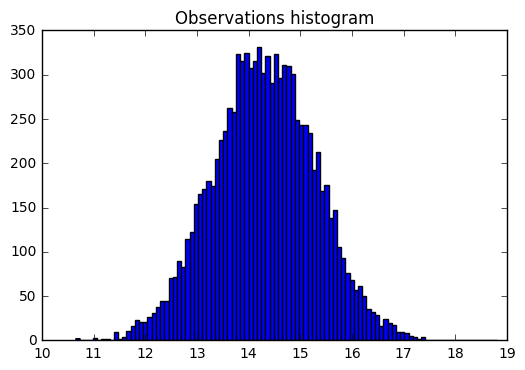

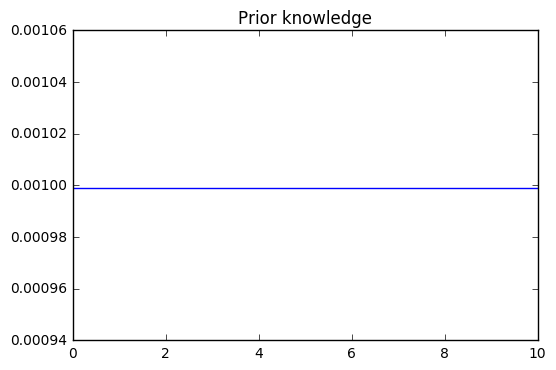

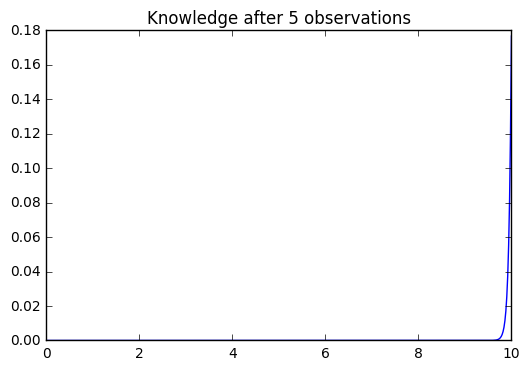

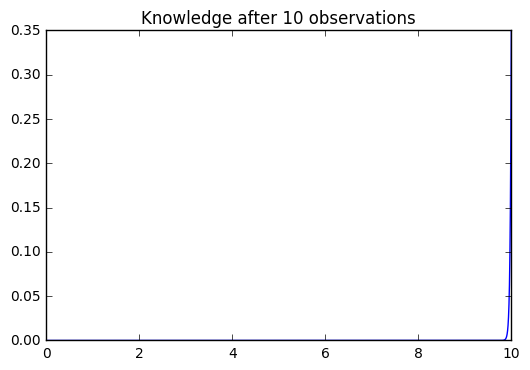

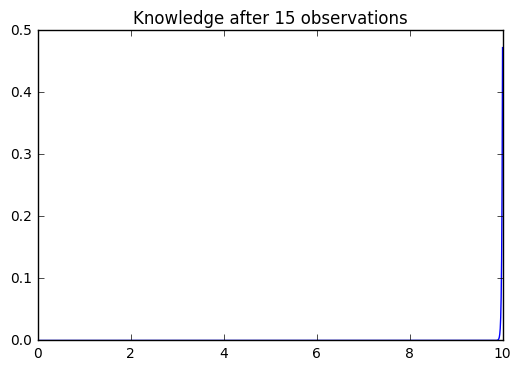

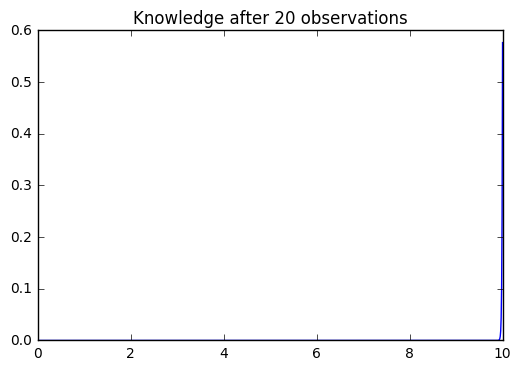

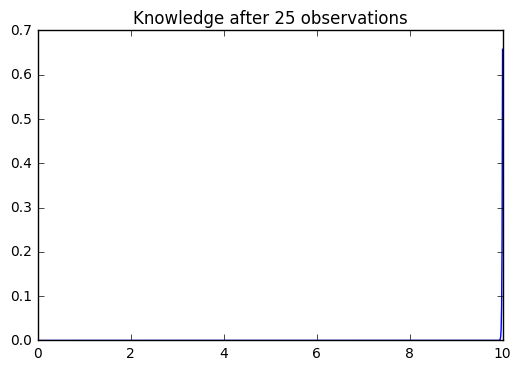

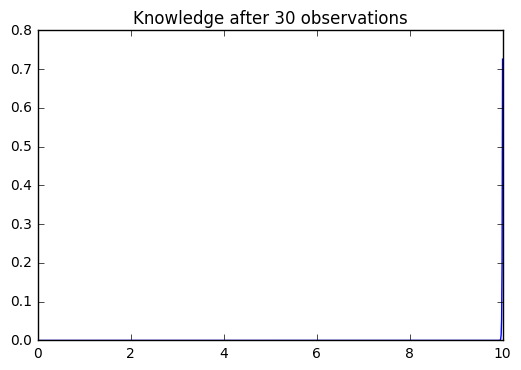

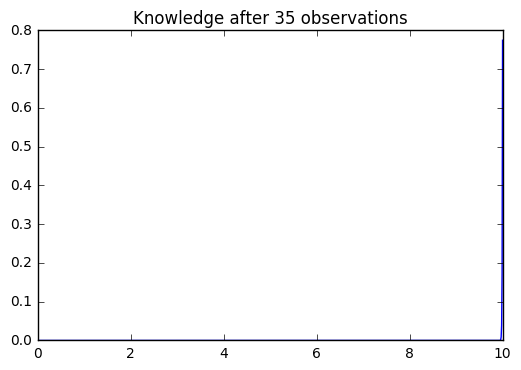

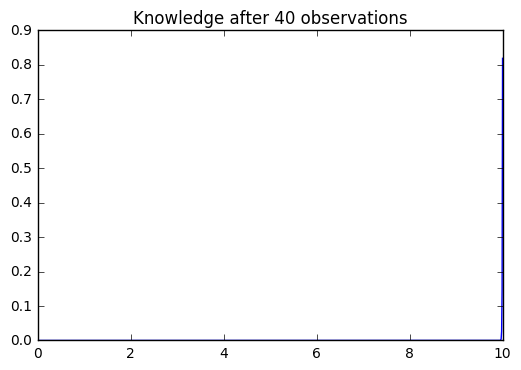

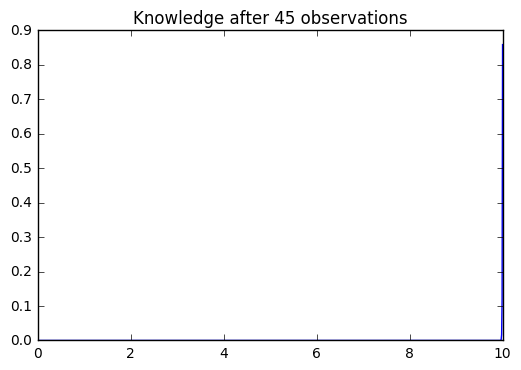

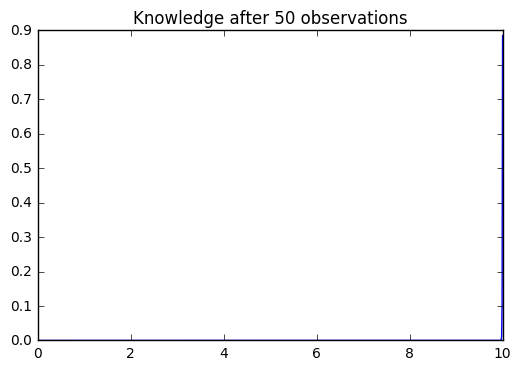

In [9]:
# przesuńmy prawdziwą średnią poza siatkę (na prawo)
knowledge = initialize_knowledge()
true_mean = 14.3
print "true_mean:", true_mean
print "true_stdev:", true_stdev
rng = np.random.RandomState(743)
observations = rng.normal(loc=true_mean, scale=true_stdev, size=10000)
plot_observations(observations)
plot_learning(prior_knowledge=knowledge, observations=observations, nb_batch=10, batch_size=5)
# model nauczył się przewidywać prawy koniec siatki

true_mean: 4.3
true_stdev: 1.0


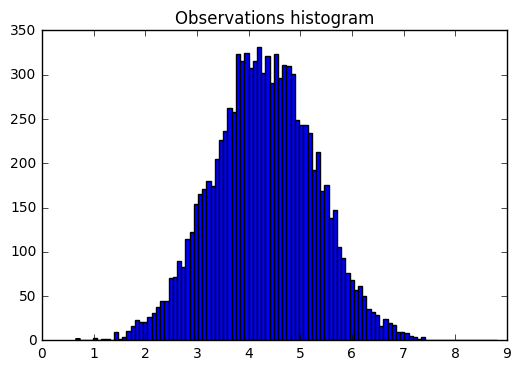

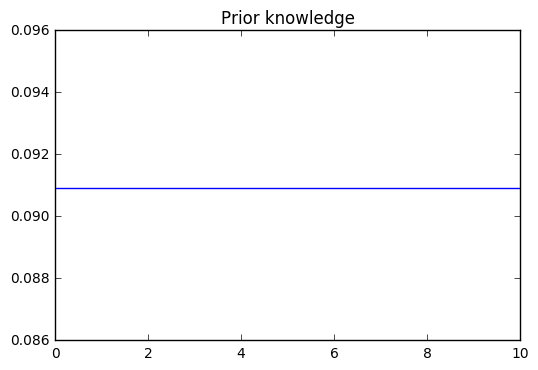

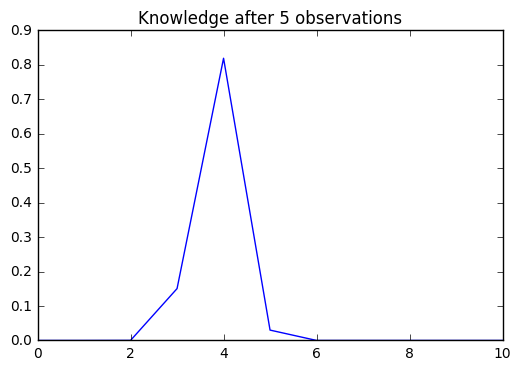

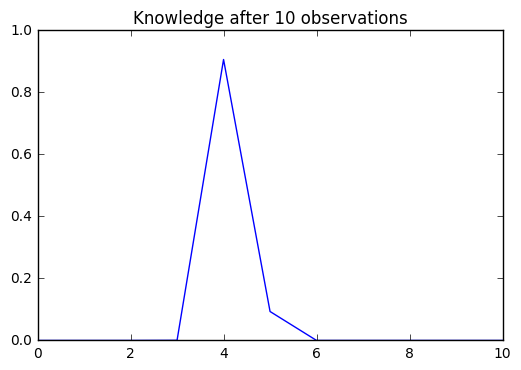

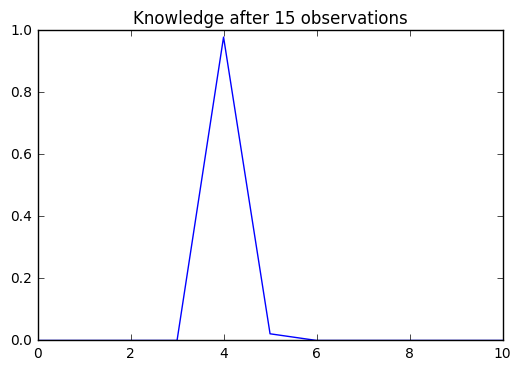

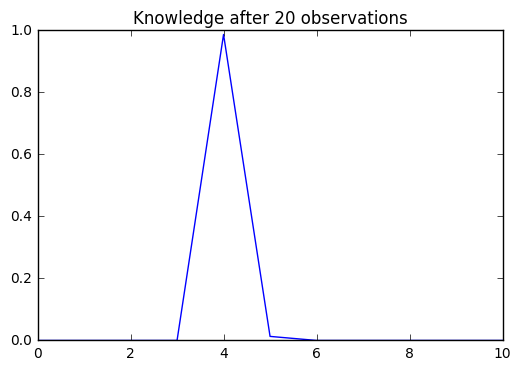

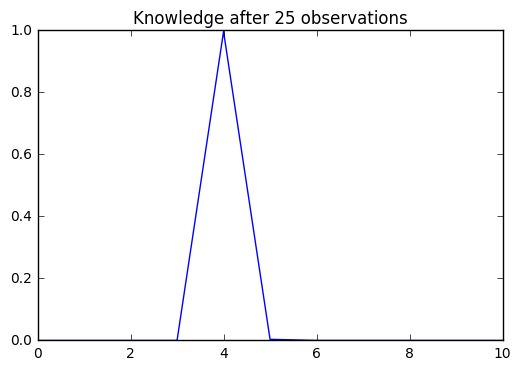

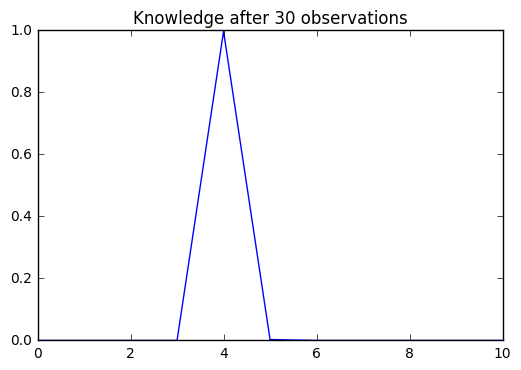

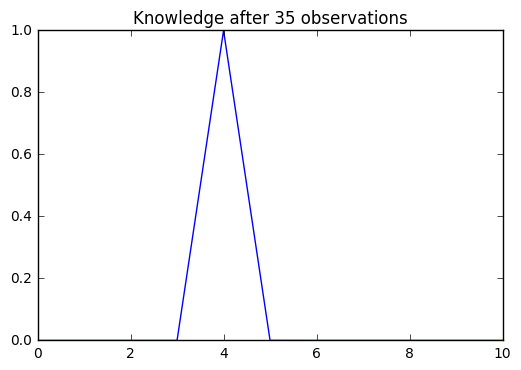

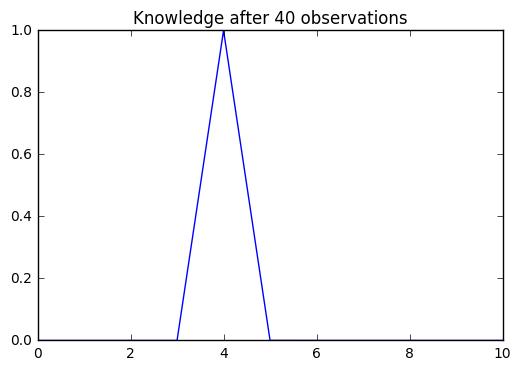

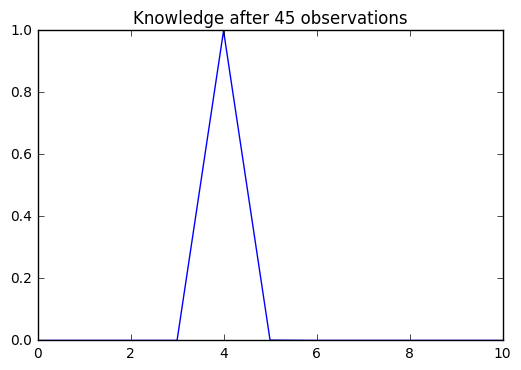

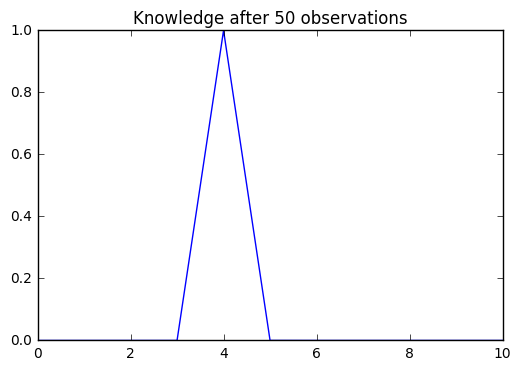

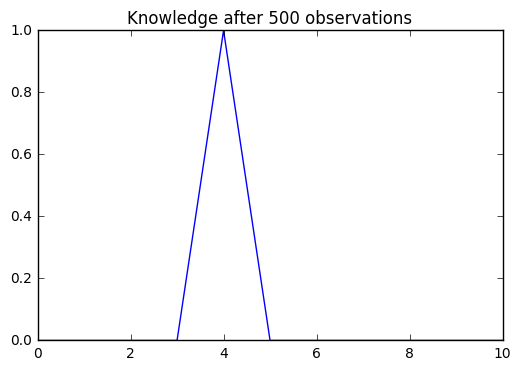

In [10]:
# zobaczmy teraz, co się stanie, gdy prawdziwa średnia obserwacji w zakresie siatki, ale poza nią
knowledge = initialize_knowledge(l_interval=0., r_interval=10., mesh_size=11, random_state=743)
true_mean, true_stdev = 4.3, 1.
print "true_mean:", true_mean
print "true_stdev:", true_stdev
rng = np.random.RandomState(743)
observations = rng.normal(loc=true_mean, scale=true_stdev, size=10000)
plot_observations(observations)
plot_learning(prior_knowledge=knowledge, observations=observations, nb_batch=10, batch_size=5)
plot_knowledge(calculate_posterior_knowledge(knowledge, observations[:500]), title="Knowledge after 500 observations")
# model nauczył się przewidywać najbliższą średnią, która miała niezerowe prawdopodobieństwo a priori

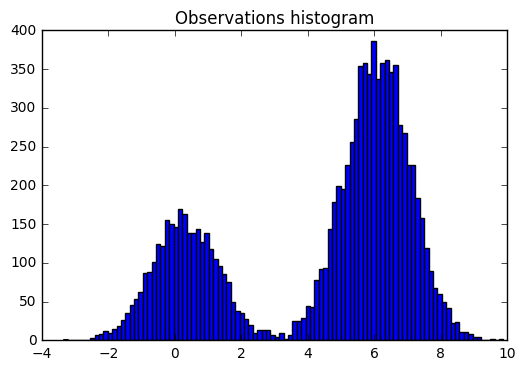

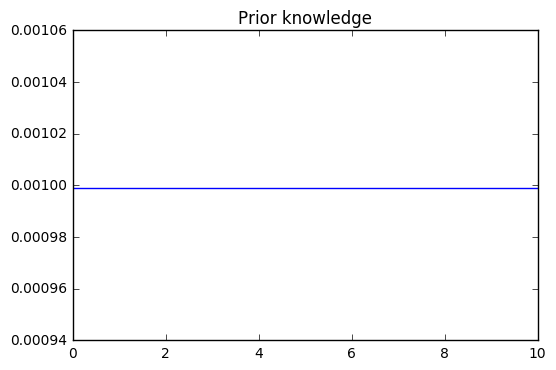

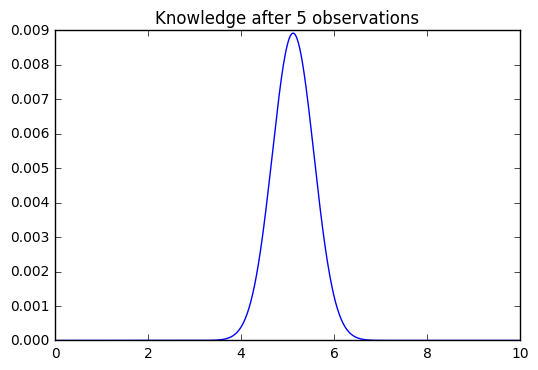

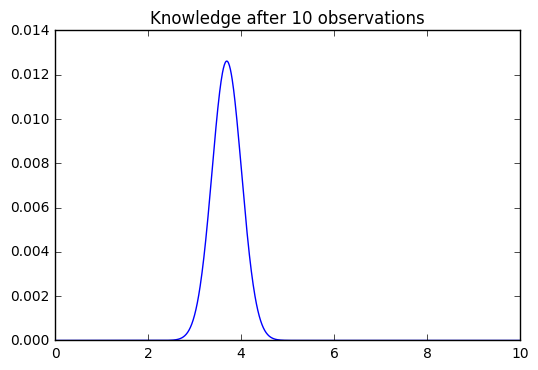

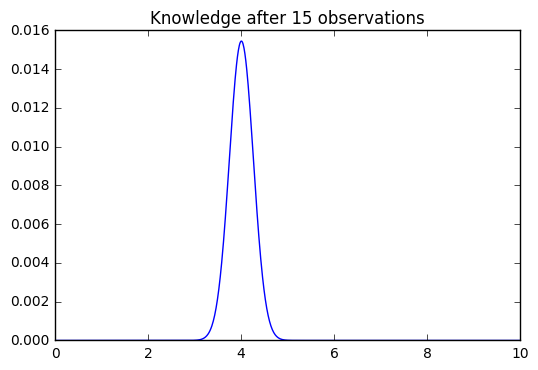

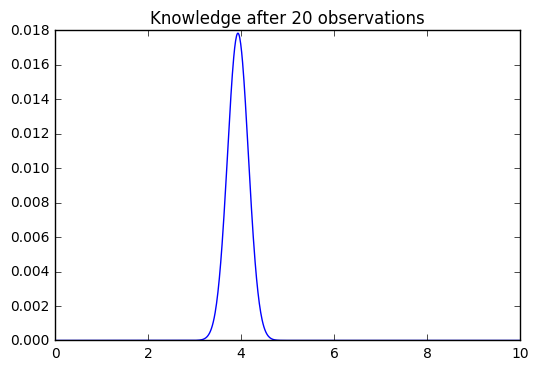

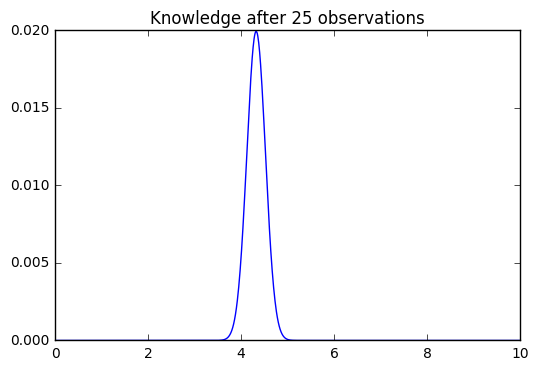

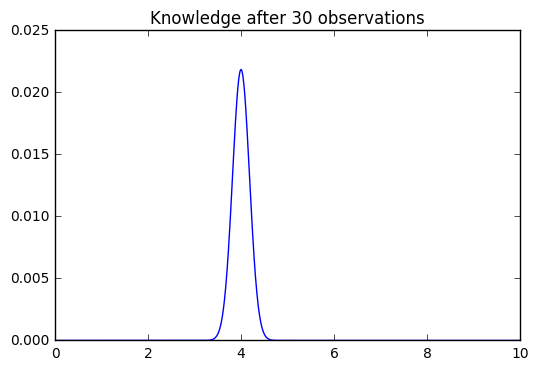

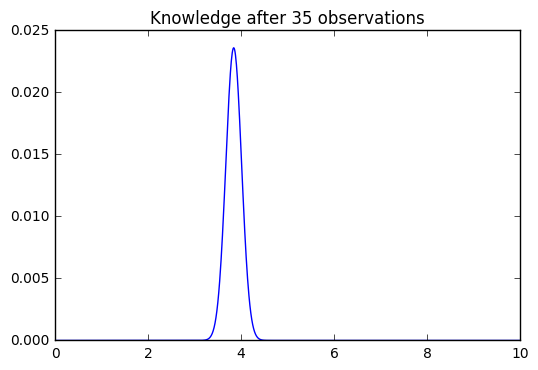

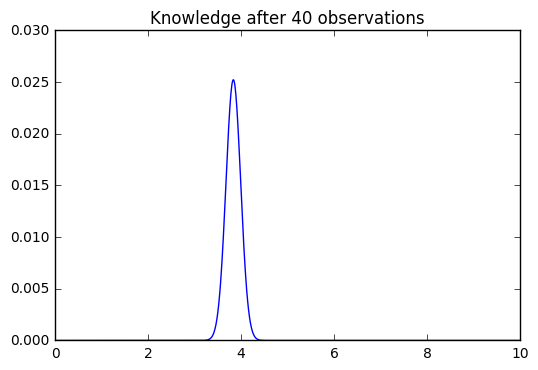

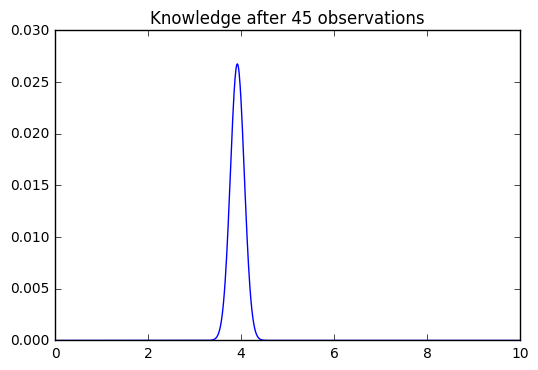

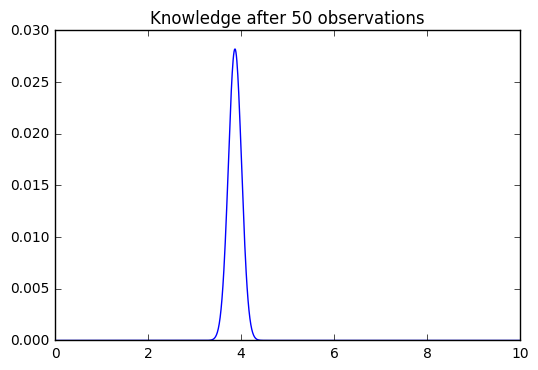

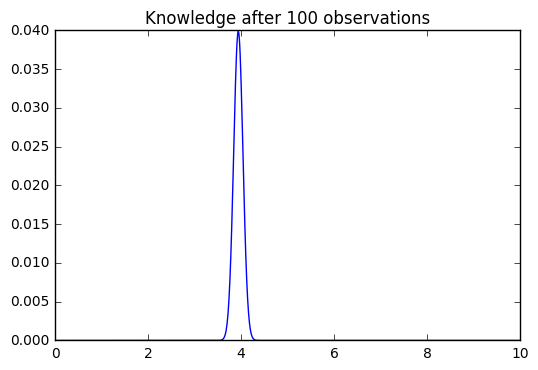

In [11]:
# ostatni eksperyment - niech obserwacje pochodzą z dwóch rozkładów gaussa
knowledge = initialize_knowledge()
rng = np.random.RandomState(743)
observations_1 = rng.normal(loc=.3, scale=1., size=3000)
observations_2 = rng.normal(loc=6.1, scale=1., size=7000)
observations = np.hstack([observations_1, observations_2])
rng.shuffle(observations)
plot_observations(observations)
plot_learning(prior_knowledge=knowledge, observations=observations, nb_batch=10, batch_size=5)
plot_knowledge(calculate_posterior_knowledge(knowledge, observations[:100]), title="Knowledge after 100 observations")
# model zgłupiał, stara się dobrać gaussa gdzieś pomiędzy (ważąc stosunkiem liczby przykładów z dwóch gaussów)